In [1]:
import json
from collections import Counter, defaultdict, deque
import gc

import numpy as np
import pandas as pd
import glob
import time
from tqdm import tqdm

from sklearn import model_selection, metrics
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sn

import lightgbm as lgb
from scipy.stats import skew

import feather
import pickle
import h5py

from concurrent import futures
#import riiideducation

In [2]:
sakami = pd.read_csv("./sakami-1221.csv")
sakami2 = np.load("./sakami-134pp.npy")
sakami["sakami2"] = sakami2
pocket_1221 = pd.read_csv("./pred_1221.csv")
pocket_1223 = pd.read_csv("./pred_1223.csv")
pocket_1226 = pd.read_csv("./pred_1226.csv")
owruby = pd.read_csv("./owruby_v022.csv")
owruby2_1 = pd.read_csv("./owruby_v026_1.csv")
owruby2_2 = pd.read_csv("./owruby_v026_2.csv")
owruby2_3 = pd.read_csv("./owruby_v026_3.csv")
owruby2_4 = pd.read_csv("./owruby_v026_4.csv")
merged = owruby.copy()
merged["pocket_1221"] = pocket_1221
merged["pocket_1223"] = pocket_1223
merged["pocket_1226"] = pocket_1226
merged["owruby"] = merged["answered_correctly"]
merged["owruby2_1"] = owruby2_1["answered_correctly"]
merged["owruby2_2"] = owruby2_2["answered_correctly"]
merged["owruby2_3"] = owruby2_3["answered_correctly"]
merged["owruby2_4"] = owruby2_4["answered_correctly"]
merged.drop(columns="answered_correctly", inplace=True)
merged2 = pd.merge(merged, sakami, on="row_id", how="inner")
merged2["sakami"] = merged2["prediction"]
merged2.drop(columns="prediction", inplace=True)
merged2["owruby2"] = (merged2["owruby2_1"] + merged2["owruby2_2"] + merged2["owruby2_3"] + merged2["owruby2_4"]) / 4

In [3]:
valid_feats = pd.read_feather("./valid_1226.feather")

In [4]:
valid_feats.shape

(5000000, 70)

In [5]:
merged = pd.concat([merged2, valid_feats], axis=1)

In [6]:
merged.head()

,row_id,label,pocket_1221,pocket_1223,pocket_1226,owruby,owruby2_1,owruby2_2,owruby2_3,owruby2_4,...,u_td_p2p3,u_td_p3p4,u_td_p4p5,u_td_p5p6,u_td_p6p7,u_td_p7p8,u_td_p8p9,u_td_p9p10,ut_ac_mean,ut_ac_mean2
0,70629059,1,0.899222,0.882067,0.871062,0.851218,0.818395,0.762108,0.795984,0.824208,...,325317.0,454170.0,2732487.0,143467.0,190046.0,182226.0,190944.0,110019856.0,0.705882,0.688819
1,70629060,1,0.875296,0.861982,0.866829,0.832965,0.817051,0.821449,0.836079,0.826704,...,820188.0,325317.0,454170.0,2732487.0,143467.0,190046.0,182226.0,190944.0,0.737113,0.711192
2,70629061,0,0.765987,0.749301,0.758079,0.835464,0.769723,0.787055,0.767097,0.817363,...,820188.0,325317.0,454170.0,2732487.0,143467.0,190046.0,182226.0,190944.0,0.705882,0.688819
3,59577091,1,0.831968,0.776635,0.764286,0.775140,0.677333,0.759442,0.770177,0.745514,...,2243661.0,657769.0,720899.0,597984.0,415187.0,527912.0,407554.0,291635.0,0.647059,0.645833
4,59577092,1,0.924458,0.946935,0.956017,0.970708,0.957377,0.920569,0.961104,0.980009,...,56203.0,2243661.0,657769.0,720899.0,597984.0,415187.0,527912.0,407554.0,0.750000,0.812500


In [7]:
merged["pocket_error"] = merged["label"] - merged["pocket_1226"]
merged["sakami_error"] = merged["label"] - merged["sakami2"]
merged["owruby_error"] = merged["label"] - merged["owruby2"]

In [8]:
error_col = ["pocket_error", "sakami_error", "owruby_error"]
merged[error_col].describe()

,pocket_error,sakami_error,owruby_error
count,5.000000e+06,5.000000e+06,5.000000e+06
mean,-2.245755e-04,3.185679e-03,4.174748e-04
std,4.119616e-01,4.098020e-01,4.092362e-01
min,-9.995643e-01,-9.983139e-01,-9.999724e-01
25%,-3.357953e-01,-3.085136e-01,-3.237156e-01
50%,8.418320e-02,6.144157e-02,7.018215e-02
75%,2.893582e-01,2.859180e-01,2.862053e-01
max,9.950849e-01,9.964529e-01,9.989500e-01


<AxesSubplot:ylabel='Frequency'>

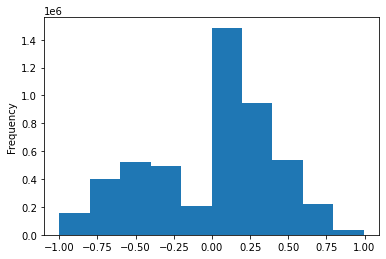

In [9]:
merged["pocket_error"].plot(kind="hist")

<AxesSubplot:>

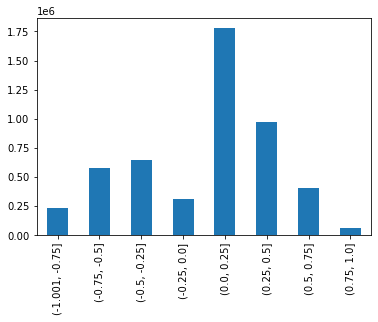

In [10]:
out = pd.cut(merged["pocket_error"], bins=[-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0], include_lowest=True)
out.value_counts(sort=False).plot(kind="bar")

<AxesSubplot:ylabel='Frequency'>

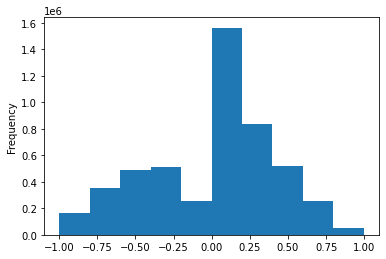

In [11]:
merged["sakami_error"].plot(kind="hist")

In [12]:
rec = merged[merged["uc_ac_cnt"]>0].copy()

In [13]:
metrics.roc_auc_score(rec["label"], rec["pocket_1226"])

0.821014621071501

In [14]:
metrics.roc_auc_score(rec["label"], rec["sakami2"])

0.8130226929952834

In [15]:
metrics.roc_auc_score(rec["label"], rec["owruby2"])

0.811522663291244

In [18]:
for seqlen in [10, 20, 30, 50, 100, 1000]:
    early = merged[merged["u_cnt"]<seqlen].copy()
    print("---------------")
    print("seqlen=", seqlen)
    print("pocket=", metrics.roc_auc_score(early["label"], early["pocket_1226"]))
    print("sakami=", metrics.roc_auc_score(early["label"], early["sakami2"]))
    print("owruby=", metrics.roc_auc_score(early["label"], early["owruby2"]))

---------------
seqlen= 10
pocket= 0.7524096699953018
sakami= 0.7545528325166928
owruby= 0.7335434366888396
---------------
seqlen= 20
pocket= 0.7646553643687308
sakami= 0.7687948014840911
owruby= 0.7592476834510595
---------------
seqlen= 30
pocket= 0.7714079825266816
sakami= 0.7763406929674674
owruby= 0.7699846680220305
---------------
seqlen= 50
pocket= 0.7810316246852755
sakami= 0.7871385172698876
owruby= 0.7816377301168334
---------------
seqlen= 100
pocket= 0.7895165576295046
sakami= 0.7966328760672642
owruby= 0.7918713170745585
---------------
seqlen= 1000
pocket= 0.7996567629931363
sakami= 0.8060078775095596
owruby= 0.8052174811172652


In [61]:
early = merged[merged["u_cnt"]<10].copy()

In [62]:
metrics.roc_auc_score(early["label"], early["pocket_1226"])

0.7524096699953018

In [63]:
metrics.roc_auc_score(early["label"], early["sakami2"])

0.7545528325166928

In [ ]:
metrics.roc_auc_score(early["label"], early["owruby"])

In [47]:
late = merged[merged["u_cnt"]>=50].copy()

In [48]:
metrics.roc_auc_score(late["label"], late["pocket_1226"])

0.8030578168543245

In [49]:
metrics.roc_auc_score(late["label"], late["sakami2"])

0.8079987650590386

In [25]:
rec["sakami_error"].abs().mean()

0.2906909382486012

In [26]:
rec["owruby_error"].abs().mean()

0.2967229419061886

<AxesSubplot:ylabel='Frequency'>

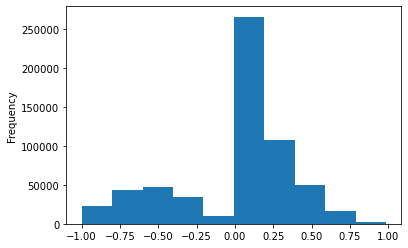

In [15]:
rec["pocket_error"].plot(kind="hist")

<AxesSubplot:ylabel='Frequency'>

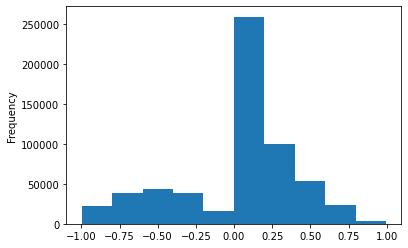

In [16]:
rec["sakami_error"].plot(kind="hist")

In [56]:
class SingleLgb:
    def __init__(self, seed=99, dry_run=False):
        self.train_param = self.get_param()
        if dry_run:
            self.num_rounds = 100
        else:
            self.num_rounds = 1000

    def do_train_direct(self, x_train, x_test, y_train, y_test):
        lgb_train = lgb.Dataset(x_train, y_train)
        lgb_eval = lgb.Dataset(x_test, y_test)

        # print('Start training...')
        model = lgb.train(self.train_param,
                          lgb_train,
                          valid_sets=[lgb_eval],
                          verbose_eval=100,
                          num_boost_round=self.num_rounds,
                          early_stopping_rounds=100,
                          #categorical_feature=[]
                         )
        # print('End training...')
        return model

    @staticmethod
    def show_feature_importance(model, filename=None):
        fi = pd.DataFrame({
            "name": model.feature_name(),
            "importance_split": model.feature_importance(importance_type="split").astype(int),
            "importance_gain": model.feature_importance(importance_type="gain").astype(int),
        })
        fi = fi.sort_values(by="importance_gain", ascending=False)
        #print(fi)
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
            print(fi)

    @staticmethod
    def get_param():
        return {
            'num_leaves': 127,
            'min_data_in_leaf': 100,
            'objective': 'binary',
            #'metric': 'auc',
            'metric': 'binary_logloss',
            'max_depth': -1,
            'learning_rate': 0.02,
            "boosting": "gbdt",
            "feature_fraction": 0.9,
            "verbosity": -1,
            "random_state": 81,
        }
    
class SingleTrainer:
    def __init__(self, pred_col, dry_run=False):
        self.pred_col = pred_col
        self.target_col = "ac"
        self.dry_run = dry_run
        self.val_size = 2*1000*1000

    def train_model(self, df):
        X = df[self.pred_col]
        y = df[self.target_col]
        
        models, scores = list(), list()
        for fold in range(4):
            print("---------")
            print("fold=", fold)
            f, c = fold, self.val_size
            val_s, val_e = -c-f*c, len(df)-f*c
            train_idx = -c-f*c
            X_train, X_val = X.iloc[:train_idx], X.iloc[val_s:val_e]
            y_train, y_val = y.iloc[:train_idx], y.iloc[val_s:val_e]
            print(X_train.shape, X_val.shape)
            
            lgbm = SingleLgb(seed=99, dry_run=self.dry_run)
            model = lgbm.do_train_direct(X_train, X_val, y_train, y_val)
            score = model.best_score["valid_0"]["binary_logloss"]
            pred = model.predict(X_val)
            score = metrics.roc_auc_score(y_val, pred)
            print("AUC=", score)
            if fold == 0:
                lgbm.show_feature_importance(model)
            models.append(model)
            scores.append(score)
            break
        return models, np.mean(scores)

In [57]:
pred_col = [
    "et",  "q_ac_cnt",  'b_ac_mean', 'b_ac_cnt', "q_ac_mean",
    "u_ac_mean", "u_cnt", "u_qm_mean", #"u_td", #"uc_td",
    "u_ac_cnt", #"u_et_cnt"
    'u_ok_qm_mean', 'u_ng_qm_mean',
    'q_et_mean', 'q_et_cnt', 'q_et_std',
   "up_ac_cnt", "up_ac_mean",
    "u_td", 
    "q_ng_uac_mean","q_ok_uac_mean", "q_ok_uac_std", "q_ng_uac_std",
    "correct_answer",
    "u_ac_mean20",
    "ulr_ac_mean", #"ulr_ac_cnt",  "ub_cnt",
    "ut_ac_mean","ut_ac_mean2",
    "uca_ac_mean", 
    "ul_td", "u_td_wl", 
    #"q_pqhe_true_uac_mean", "q_pqhe_true_uac_std", "q_pqhe_false_uac_mean", "q_pqhe_false_uac_std",
    #"pqhe",
    "uc_td", "uc_ac_mean", "uc_ac_cnt", 
    #"u_td_final", #"ub_td_final"
    'u_td_tp1','u_td_p1p2', 'u_td_p2p3', 'u_td_p3p4', 'u_td_p4p5',
    'u_td_p5p6', 'u_td_p6p7', 'u_td_p7p8', 'u_td_p8p9', 'u_td_p9p10',
    "uac_prev1", "uac_prev2",
    "elo_beta", "u_elo_theta", 
    "u_rate",
]
nn_col = [f"nn_svd{i}" for i in range(20)]
pred_col += nn_col
print(pred_col)

['et', 'q_ac_cnt', 'b_ac_mean', 'b_ac_cnt', 'q_ac_mean', 'u_ac_mean', 'u_cnt', 'u_qm_mean', 'u_ac_cnt', 'u_ok_qm_mean', 'u_ng_qm_mean', 'q_et_mean', 'q_et_cnt', 'q_et_std', 'up_ac_cnt', 'up_ac_mean', 'u_td', 'q_ng_uac_mean', 'q_ok_uac_mean', 'q_ok_uac_std', 'q_ng_uac_std', 'correct_answer', 'u_ac_mean20', 'ulr_ac_mean', 'ut_ac_mean', 'ut_ac_mean2', 'uca_ac_mean', 'ul_td', 'u_td_wl', 'uc_td', 'uc_ac_mean', 'uc_ac_cnt', 'u_td_tp1', 'u_td_p1p2', 'u_td_p2p3', 'u_td_p3p4', 'u_td_p4p5', 'u_td_p5p6', 'u_td_p6p7', 'u_td_p7p8', 'u_td_p8p9', 'u_td_p9p10', 'uac_prev1', 'uac_prev2', 'elo_beta', 'u_elo_theta', 'u_rate', 'nn_svd0', 'nn_svd1', 'nn_svd2', 'nn_svd3', 'nn_svd4', 'nn_svd5', 'nn_svd6', 'nn_svd7', 'nn_svd8', 'nn_svd9', 'nn_svd10', 'nn_svd11', 'nn_svd12', 'nn_svd13', 'nn_svd14', 'nn_svd15', 'nn_svd16', 'nn_svd17', 'nn_svd18', 'nn_svd19']


In [89]:
pred_col = [
    "owruby2", "pocket_1226", "sakami2",
    #"owruby2", "sakami", "pocket_1223",
    "uc_td", "uc_ac_mean", 
    "ul_td", "u_td", "u_td_p1p2", 
    "ut_ac_mean", "ut_ac_mean2",
    "up_ac_mean", 
    "et", "q_et_mean", "q_et_std",
    "u_elo_theta", "q_ac_mean", 
    "up_ac_cnt", "uc_ac_cnt", "u_cnt", "q_ac_cnt"
]
# pred_col += [
#     "et",  "q_ac_cnt",  'b_ac_mean', 'b_ac_cnt', "q_ac_mean",
#     "u_ac_mean", "u_cnt", "u_qm_mean", #"u_td", #"uc_td",
#     "u_ac_cnt", #"u_et_cnt"
#     'u_ok_qm_mean', 'u_ng_qm_mean',
#     'q_et_mean', 'q_et_cnt', 'q_et_std',
#    "up_ac_cnt", "up_ac_mean",
#     "u_td", 
#     "q_ng_uac_mean","q_ok_uac_mean", "q_ok_uac_std", "q_ng_uac_std",
#     #"correct_answer",
#     #"u_ac_mean20",
#     "ulr_ac_mean", #"ulr_ac_cnt",  "ub_cnt",
#     "ut_ac_mean","ut_ac_mean2",
#     "uca_ac_mean", 
#     "ul_td", "u_td_wl", 
#     #"q_pqhe_true_uac_mean", "q_pqhe_true_uac_std", "q_pqhe_false_uac_mean", "q_pqhe_false_uac_std",
#     #"pqhe",
#     "uc_td", "uc_ac_mean", "uc_ac_cnt", 
#     #"u_td_final", #"ub_td_final"
#     'u_td_tp1','u_td_p1p2', 'u_td_p2p3', 'u_td_p3p4', 'u_td_p4p5',
# #     'u_td_p5p6', 'u_td_p6p7', 'u_td_p7p8', 'u_td_p8p9', 'u_td_p9p10',
#     #"uac_prev1", "uac_prev2",
#     "elo_beta", "u_elo_theta", 
#     "u_rate",
# ]

In [90]:
trainer = SingleTrainer(pred_col, dry_run=False)
models, score = trainer.train_model(merged)

---------
fold= 0
(3000000, 20) (2000000, 20)
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.504947
[200]	valid_0's binary_logloss: 0.498862
[300]	valid_0's binary_logloss: 0.498466
[400]	valid_0's binary_logloss: 0.498397
[500]	valid_0's binary_logloss: 0.498377
[600]	valid_0's binary_logloss: 0.498368
[700]	valid_0's binary_logloss: 0.498372
Early stopping, best iteration is:
[621]	valid_0's binary_logloss: 0.498366
AUC= 0.8140457986159788
           name  importance_split  importance_gain
0       owruby2              6861         13598779
2       sakami2              6995          9289324
1   pocket_1226              7720           461220
3         uc_td              3847            79792
5         ul_td              5320            75017
4    uc_ac_mean              2048            56671
6          u_td              4378            55528
15    q_ac_mean              4471            55350
14  u_elo_theta              4171            4

In [84]:
models[0].save_model("./ensemble_model_1229.lgb")

In [55]:
# base feats
#Early stopping, best iteration is:
#[295]	valid_0's binary_logloss: 0.517508
#AUC= 0.7967711921542647

# with owruby, sakami
# [73]	valid_0's binary_logloss: 0.499981
#AUC= 0.812631130956799

# add pocket1223
#AUC= 0.8130389687940041

#just 3
#AUC= 0.8119216727001559

# just3 + top feats
#0.81279

In [22]:
metrics.roc_auc_score(merged2["label"], merged2["ranked_3avg"])

0.8115313781174149

In [17]:
for power in [1.5, 1.75, 2, 2.25, 2.5, 3, 3.5, 4]:
    merged2["power_mean"] = (merged2["sakami"]**power + merged2["owruby"]**power + merged2["pocket_1223"]**power)
    score = metrics.roc_auc_score(merged2["label"], merged2["power_mean"])
    print(power, score)

1.5 0.8115757793963951
1.75 0.8115617807361065
2 0.8115436387419797
2.25 0.8115220983411143
2.5 0.8114978412488558
3 0.811442840131525
3.5 0.8113818106061845
4 0.8113171371978005
